In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
df = pd.read_csv('/dlabdata1/lugeon/websites_dmoz_multi.gz', index_col=0)
df

/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,uid,url,lang,lang_id,cat0
0,184,www.delphipraxis.net,Deutsch,de,Computers
1,263,www.central-it.de,Deutsch,de,Computers
2,731,www.aus-wandern.de,Deutsch,de,Computers
3,1072,blog.cvjm-nuernberg.de,Deutsch,de,Computers
4,1101,www.ges-training.de,Deutsch,de,Computers
...,...,...,...,...,...
1025176,2488203,www.stompin-ground.com,English,en,Arts
1025177,2488226,www.quarrypark.co.uk,English,en,Sports
1025178,2488230,www.sugarcreekwines.com,English,en,Recreation
1025179,2488233,www.aera.net,English,en,Reference


In [6]:
def clean_url(url):
    url = re.sub(r"www.|http://|https://|-|_", '', url)
    return url.split('.')[0]

In [7]:
df_fr['clean_url'] = df_fr.apply(lambda row: clean_url(row.url), axis=1)

<ipython-input-7-69c4f9be8978>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr['clean_url'] = df_fr.apply(lambda row: clean_url(row.url), axis=1)


In [9]:
def compute_ngram(s, n):
    return [s[i:i+n] for i in range(0, len(s)-n+1)]

def concat_ngrams(s, ns):
    l = []
    for n in ns:
        l += compute_ngram(s, n)
    return list(set(l))

In [21]:
df_en = df[df.lang_id == 'en']
df_en.cat0.value_counts()

Business      148144
Society        82079
Arts           66721
Shopping       54062
Recreation     46095
Computers      45194
Sports         34890
Science        28138
Health         24218
Reference      21663
Games          10246
Home            6952
News            3696
Name: cat0, dtype: int64

In [137]:
df_bal = df_en.groupby('cat0').sample(3696, random_state=42)

In [138]:
df_bal['clean_url'] = df_bal.apply(lambda row: clean_url(row.url), axis=1)

In [139]:
df_bal

,uid,url,lang,lang_id,cat0,clean_url
673989,965931,www.donniemunro.co.uk,English,en,Arts,donniemunro
658417,897717,www.illustrationfriday.com,English,en,Arts,illustrationfriday
580822,557451,www.derekboshier.com,English,en,Arts,derekboshier
589512,595760,www.mplatzer.info,English,en,Arts,mplatzer
942745,2129982,addictedtobritney.tripod.com,English,en,Arts,addictedtobritney
...,...,...,...,...,...,...
557013,452002,www.myfootygrounds.co.uk,English,en,Sports,myfootygrounds
781283,1428039,www.fspnet.com,English,en,Sports,fspnet
542033,386133,www.rmqha.com,English,en,Sports,rmqha
496719,188285,www.weaverleather.com,English,en,Sports,weaverleather


In [140]:
ns = range(3, 7) # from 3 to 6
df_bal['ngrams'] = df_bal.apply(lambda row: concat_ngrams(row.clean_url, ns), axis=1)

In [154]:
categories = df_bal.cat0.unique()

def categorize(c):
    return categories.tolist().index(c)

In [ ]:
df_bal['catno'] = df_bal.apply(lambda row: categorize(row.cat0), axis=1)

In [141]:
ix = np.arange(df_bal.shape[0])
np.random.shuffle(ix)
sep = int((1 - 0.2) * df_bal.shape[0])
train = df_bal.iloc[ix[:sep]]
test = df_bal.iloc[ix[sep:]]

In [142]:
train.cat0.value_counts()

Sports        3020
Computers     2984
Recreation    2978
Health        2975
Home          2974
Games         2970
Science       2963
News          2957
Shopping      2942
Reference     2940
Society       2936
Arts          2906
Business      2893
Name: cat0, dtype: int64

In [143]:
test.cat0.value_counts()

Business      803
Arts          790
Society       760
Reference     756
Shopping      754
News          739
Science       733
Games         726
Home          722
Health        721
Recreation    718
Computers     712
Sports        676
Name: cat0, dtype: int64

In [147]:
train_bycat = train[['cat0', 'ngrams']].groupby('cat0').agg(lambda col: [s for l in col for s in l])

In [148]:
def top_ngrams(l):
    return pd.Series(l).value_counts().to_dict()

In [149]:
train_bycat['top_ngrams_count'] = train_bycat.apply(lambda row: top_ngrams(row.ngrams), axis=1)

In [373]:
def reduce_ngrams(ngrams_dict, nb_rep_ngrams):
    red = set()
    for s in ngrams_dict.keys(): # candidate
        valid = True
        init_count = ngrams_dict[s]
        for t in list(ngrams_dict.keys()): # superstring
            if len(t) > len(s): # longest substring
                if s in t: # if there is a super-string in the ngrams
                    if (init_count - ngrams_dict[t])/init_count <= 0.4: # and that there count difference is smaller or equal than 2
                        s = t # discard substring
        if valid:
            red.add(s)
        if len(red) == nb_rep_ngrams:
            break
                
    return red

In [374]:
nb_rep_ngrams = 20

train_bycat['rep_ngrams'] = train_bycat.apply(lambda row: reduce_ngrams(row.top_ngrams_count, nb_rep_ngrams), axis=1)

In [375]:
train_bycat

,ngrams,top_ngrams_count,rep_ngrams
cat0,,,
Arts,"[oefi, fino, oefino, joe, efino, fin, joefi, e...","{'the': 175, 'art': 159, 'and': 153, 'ing': 12...","{the, art, and, tion, eat, ers, est, ing, all,..."
Business,"[terlin, ling, rlingp, recisi, terl, lingp, gp...","{'ing': 198, 'ion': 140, 'ter': 111, 'tio': 11...","{inc, and, ent, tion, ica, pro, ers, int, tra,..."
Computers,"[mycom, rma, mpute, terman, uterm, ycom, compu...","{'web': 124, 'ing': 123, 'ion': 122, 'oft': 11...","{ware, tion, nter, pro, ers, web, tra, ing, de..."
Games,"[bal, ocf, cfoos, sball, oosba, ocfoo, ball, o...","{'gam': 265, 'ame': 237, 'game': 221, 'ing': 1...","{the, and, ent, ion, line, ers, wor, min, game..."
Health,"[boh, bohs, ohs, sforli, forl, sforl, yfrie, r...","{'ing': 193, 'ent': 167, 'lin': 158, 'ion': 15...","{the, heal, and, health, clinic, ent, tion, ce..."
Home,"[cie, ociet, acuser, roseso, useros, ciety, ra...","{'ing': 242, 'ard': 204, 'the': 186, 'den': 18...","{the, and, ent, tion, cook, che, ers, chi, foo..."
News,"[wns, swns, swn, lly, ysuck, ysu, reil, ore, e...","{'new': 456, 'ews': 440, 'news': 433, 'the': 2...","{the, herald, ournal, and, ent, sta, media, he..."
Recreation,"[onte, nmont, ranmon, mont, nmo, granm, monte,...","{'ing': 230, 'ers': 199, 'ine': 167, 'ter': 15...","{the, and, sta, tion, ers, ort, out, tra, ave,..."
Reference,"[kermi, litary, pri, milita, lita, ilit, tar, ...","{'use': 138, 'mus': 128, 'ion': 117, 'muse': 1...","{the, and, ibrary, ent, tion, colleg, ollege, ..."


In [376]:
all_rep_grams = np.unique([gram for gramlist in train_bycat.rep_ngrams for gram in gramlist])
all_rep_grams.shape

(139,)

In [377]:
all_rep_grams

array(['all', 'ance', 'and', 'ardens', 'are', 'art', 'ate', 'athlet',
       'ation', 'ave', 'ball', 'bio', 'bridge', 'camp', 'car', 'care',
       'casino', 'center', 'cha', 'che', 'chess', 'chi', 'christ',
       'church', 'clinic', 'club', 'colleg', 'com', 'con', 'cook',
       'county', 'daily', 'danc', 'design', 'ear', 'eat', 'egame', 'ent',
       'ers', 'ess', 'est', 'food', 'ftware', 'game', 'games', 'garden',
       'golf', 'heal', 'health', 'her', 'herald', 'hletic', 'home',
       'horse', 'hospit', 'ian', 'ibrary', 'ica', 'ics', 'ill', 'inc',
       'ine', 'ines', 'ing', 'int', 'inte', 'ion', 'ions', 'ist', 'ive',
       'journa', 'lab', 'lan', 'law', 'les', 'letics', 'librar', 'lin',
       'line', 'lle', 'man', 'mar', 'math', 'media', 'min', 'museum',
       'music', 'net', 'news', 'nter', 'ollege', 'olog', 'ology',
       'online', 'ons', 'ort', 'ospita', 'ournal', 'out', 'photo', 'pla',
       'port', 'press', 'pro', 'rac', 'ran', 'rea', 'recipe', 'res',
       'rin', '

In [266]:
def encode_repgrams_onehot(s, repgrams):
    onehot = np.array([int(gram in s) for gram in repgrams])
    return onehot

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

In [269]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [378]:
nb_all_ngram = []
fracs = []
train_scores = []
test_scores = []

range_rep_ngrams = [1] + list(range(10, 80, 10))

for nb_rep_ngrams in tqdm(range_rep_ngrams):

    train_bycat['rep_ngrams'] = train_bycat.apply(lambda row: reduce_ngrams(row.top_ngrams_count, nb_rep_ngrams), axis=1)

    all_rep_grams = np.unique([gram for gramlist in train_bycat.rep_ngrams for gram in gramlist])
    
    train['repgrams_oh'] = train.apply(lambda row: encode_repgrams_onehot(row.clean_url, all_rep_grams), axis=1)
    test['repgrams_oh'] = test.apply(lambda row: encode_repgrams_onehot(row.clean_url, all_rep_grams), axis=1)

    no_repgram = (train.repgrams_oh.apply(sum) == 0).value_counts()
    frac_no_repgram = (no_repgram[True] / (no_repgram[True] + no_repgram[False])) # percentage of urls without any rep ngrams
    
    x_train = np.concatenate(train[train.repgrams_oh.apply(sum) != 0].repgrams_oh.to_numpy()).ravel()
    x_train = x_train.reshape(-1, all_rep_grams.shape[0])
    
    x_test = np.concatenate(test[test.repgrams_oh.apply(sum) != 0].repgrams_oh.to_numpy()).ravel()
    x_test = x_test.reshape(-1, all_rep_grams.shape[0])
    
    y_train = train[train.repgrams_oh.apply(sum) != 0].catno.values
    
    y_test = test[test.repgrams_oh.apply(sum) != 0].catno.values

    forest = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
    forest.fit(x_train, y_train)

    train_score = precision_recall_fscore_support(y_train, forest.predict(x_train), average='weighted')
    test_score = precision_recall_fscore_support(y_test, forest.predict(x_test), average='weighted')
    
    nb_all_ngram += [len(all_rep_grams)]
    fracs += [frac_no_repgram]
    train_scores += [train_score]
    test_scores += [test_score]

100%|██████████| 8/8 [07:40<00:00, 57.59s/it]


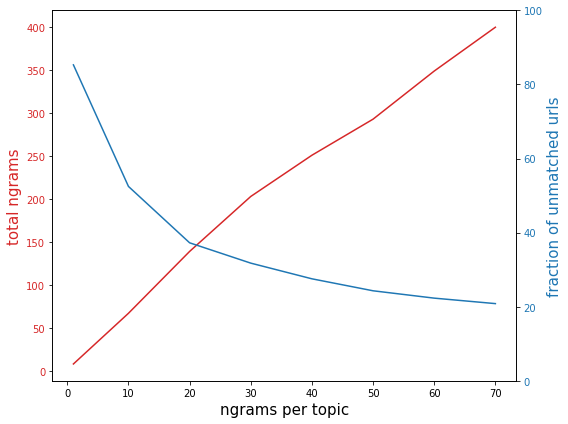

In [379]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('ngrams per topic', size=15)
ax1.set_ylabel('total ngrams', color=color, size=15)
ax1.plot(range_rep_ngrams, nb_all_ngram, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('fraction of unmatched urls', color=color, size=15)  # we already handled the x-label with ax1
ax2.plot(range_rep_ngrams, [100 * f for f in fracs], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,100])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


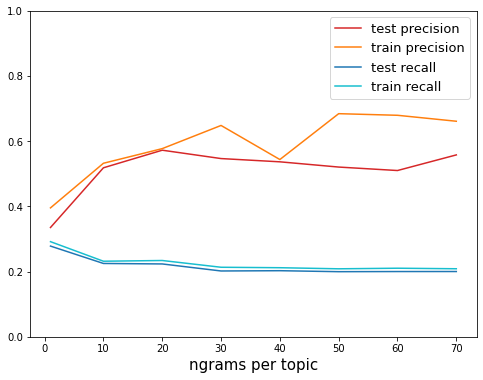

In [380]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel('ngrams per topic', size=15)

ax1.plot(range_rep_ngrams, [s[0] for s in test_scores], color='tab:red', label='test precision')
ax1.plot(range_rep_ngrams, [s[0] for s in train_scores], color='tab:orange', label='train precision')

ax1.plot(range_rep_ngrams, [s[1] for s in test_scores], color='tab:blue', label='test recall')
ax1.plot(range_rep_ngrams, [s[1] for s in train_scores], color='tab:cyan', label='train recall')

ax1.set_ylim([0,1])

plt.legend(fontsize=13)

plt.show()

Best classifier seem to be with 50 most common ngrams and a max depth of 10